In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
from albumentations import pytorch as AT
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

In [2]:
path = '/mnt/aoni04/saijo/PIS/input/understanding_cloud_organization'
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

There are 5546 images in train dataset
There are 3698 images in test dataset


In [3]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')



In [4]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks



class CloudDataset(Dataset):
    def __init__(self, path, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [5]:
#データ

In [6]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

num_workers = 0
bs = 16

train_dataset = CloudDataset(path = path, df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing = get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(path = path, df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing = get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

In [7]:
#モデル

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = '../best_dice_model.pth'
model = torch.load(model_path)

In [9]:
#loss

In [10]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.__name__ = "BCEDiceLoss"

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5 # TODO smooth may be 1?
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [11]:
loss = BCEDiceLoss()

In [12]:
#推論

In [15]:
from tqdm import tqdm
class test():
    def __init__(self, model, dataloader, device, loss, batch_size=4):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.loss = loss
        self.batch_size = batch_size
        
    def get_score(self, input, target):
        smooth = 1e-5 # TODO smooth may be 1?
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        
        return dice
        
    def run(self, aug=False):
        total_loss = 0.
        cnt = 0.
        score = 0.
        with torch.no_grad():
            for x, y in tqdm(self.dataloader):
                x=x.to(self.device)
                pred = self.model.forward(x)
                l = self.loss(pred.detach().cpu(), y.cpu())
                total_loss += l.sum().numpy()
                score += self.get_score(pred.detach().cpu(), y.cpu())
                cnt += self.batch_size

        return total_loss/cnt, score.numpy() /cnt

class TTA(test):
    def __init__(self, model, dataloader, device, loss, batch_size=4):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.loss = loss
        self.batch_size = batch_size
        
    def flip(self, x, axis):
        pred = self.model.forward(x.flip(axis).to(self.device))
        return pred
#         return pred.flip(axis)
        
    def run(self, augs_dict=None):
        total_loss = 0.
        score = 0.
        cnt = 0.
        with torch.no_grad():
            for x, y in tqdm(self.dataloader):
                x=x.to(self.device)
                pred1 = self.model.forward(x)
                pred2 = self.flip(x, 2)
                pred3 = self.flip(x, 3)
                if cnt<1:
                    print(pred1[0][0][0], pred2[0][0][0], pred3[0][0][0])
                pred = (pred1+pred2+pred3)/3.0
                l = self.loss(pred.detach().cpu(), y.cpu())
                total_loss += l.sum().numpy()
                score += self.get_score(pred.detach().cpu(), y.cpu())
                cnt += self.batch_size

        return total_loss/cnt, score.numpy() /cnt

In [16]:
tester = test(model, valid_loader, device, BCEDiceLoss())
tta_tester = TTA(model, valid_loader, device, BCEDiceLoss())

In [17]:
# loss, score = tester.run()
# print(loss)
# print(score)

In [18]:
tta_tester.run()
print(loss)
print(score)

  0%|          | 0/35 [00:00<?, ?it/s]

tensor([-2.2978, -2.3905, -2.4832, -2.5759, -2.6686, -2.7590, -2.8493, -2.9396,
        -3.0300, -3.0785, -3.1254, -3.1723, -3.2191, -3.2194, -3.2168, -3.2142,
        -3.2116, -3.1998, -3.1872, -3.1747, -3.1621, -3.1348, -3.1059, -3.0770,
        -3.0481, -3.0512, -3.0584, -3.0657, -3.0729, -3.0791, -3.0851, -3.0911,
        -3.0971, -3.0937, -3.0887, -3.0836, -3.0785, -3.0299, -2.9724, -2.9149,
        -2.8574, -2.8147, -2.7755, -2.7363, -2.6971, -2.6910, -2.6937, -2.6964,
        -2.6991, -2.7287, -2.7662, -2.8037, -2.8413, -2.8742, -2.9058, -2.9373,
        -2.9688, -2.9776, -2.9783, -2.9790, -2.9797, -3.0070, -3.0447, -3.0825,
        -3.1202, -3.1448, -3.1636, -3.1824, -3.2013, -3.2299, -3.2631, -3.2964,
        -3.3296, -3.3186, -3.2847, -3.2508, -3.2169, -3.1915, -3.1708, -3.1501,
        -3.1294, -3.1076, -3.0851, -3.0627, -3.0402, -3.0590, -3.1049, -3.1508,
        -3.1967, -3.2022, -3.1791, -3.1559, -3.1328, -3.1241, -3.1264, -3.1287,
        -3.1310, -3.1184, -3.0935, -3.06

100%|██████████| 35/35 [01:56<00:00,  3.34s/it]

BCEDiceLoss()


NameError: name 'score' is not defined

In [ ]:
-2.2978, -2.3905, -2.4832, -2.5759, -2.6686, -2.7590, -2.8493, -2.9396


In [88]:
x, y = iter(valid_loader).next()

In [89]:
def get_score(input, target):
    smooth = 1e-5 # TODO smooth may be 1?
    input = torch.sigmoid(input)
    num = target.size(0)
    input = input.view(num, -1)
    target = target.view(num, -1)
    intersection = (input * target)
    dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num

    return dice

In [47]:
transforms = albu.Compose([albu.GaussNoise(var_limit=(10.0, 50.0))])

In [94]:
transforms

Compose([
  GaussNoise(always_apply=False, p=0.5, var_limit=(10.0, 50.0)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


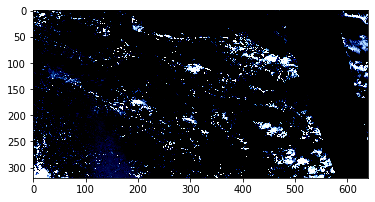

In [90]:
plt.imshow(x[0].permute(1, 2, 0))

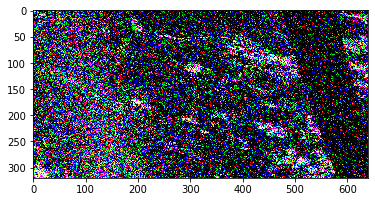

In [141]:
transforms = albu.Compose([albu.GaussNoise(var_limit=(0, 3), p=1.0)])
augmented = transforms(image=x.cpu().numpy(), mask=y.cpu().numpy())
img = augmented['image']
mask = augmented['mask']
plt.imshow(img[0].transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


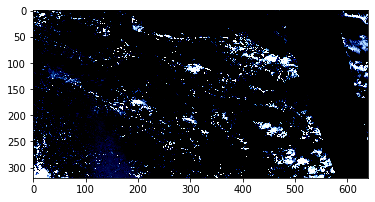

In [124]:
plt.imshow(img[0].transpose(1, 2, 0))

In [16]:
def predict(x, model, device, axis=0):
    x=x.to(device)
    if axis>0:
        x = x.flip(axis)
    pred = model.forward(x)
    if axis>0:
        score = get_score(pred.flip(axis).detach().cpu(), y.cpu())
    else:
        score = get_score(pred.detach().cpu(), y.cpu())
    print(score)

In [23]:
predict(x, model, device)

tensor(0.5236)


In [24]:
predict(x, model, device, axis=3)

tensor(0.5195)


In [25]:
predict(x, model, device, axis=2)

tensor(0.5259)


In [26]:
(0.5259+0.5195+0.5236)/3

0.523

In [20]:
x, y = iter(valid_loader).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


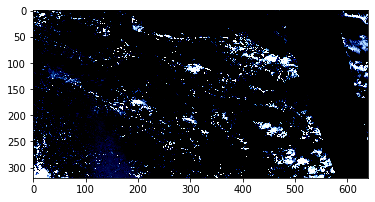

In [21]:
plt.imshow(x[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


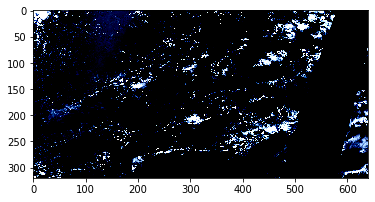

In [22]:
plt.imshow(x.flip(2)[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


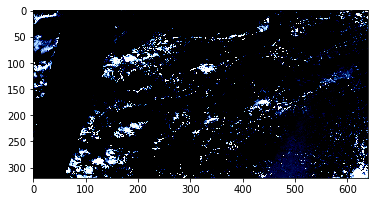

In [23]:
plt.imshow(x.flip(3)[0].permute(1, 2, 0))

In [78]:
# 黒
b, c, h, w = x.shape

pts_x = np.random.randint(0, w-1 , 100000)
pts_y = np.random.randint(0, h-1 , 100000)
pts_b = np.random.randint(0, b-1 , 100000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


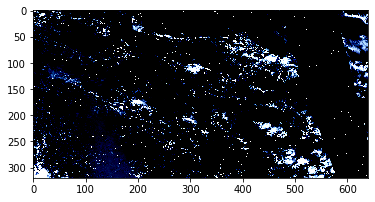

In [79]:
plt.imshow(x[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 320, 640, 3)


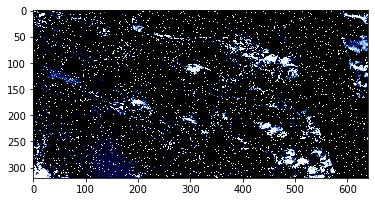

In [80]:
xx = x.cpu().numpy()
xx = xx.transpose(0, 2, 3, 1)
print(xx.shape)
# xx[(pts_b, pts_y,pts_x)] = (0, 0, 0)
xx[(pts_b, pts_y,pts_x)] = (255, 255, 255)
xx_ = torch.tensor(xx.transpose(0, 3, 1, 2))
plt.imshow(xx_[0].permute(1, 2, 0))

In [56]:
img = np.zeros((320, 640))

In [41]:
xx = x.cpu().numpy()
xx = xx.transpose(0, 2, 3, 1)
print(xx.shape)
xx[:, (pts_y,pts_x)] = (0,0,0)
plt.imshow(torch.tensor(xx)[0].permute(1, 2, 0))

(16, 320, 640, 3)


IndexError: index 553 is out of bounds for axis 1 with size 320

In [39]:
x.cpu().numpy().shape

(16, 3, 320, 640)

In [9]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [10]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [11]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [12]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


In [13]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

In [14]:
def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            

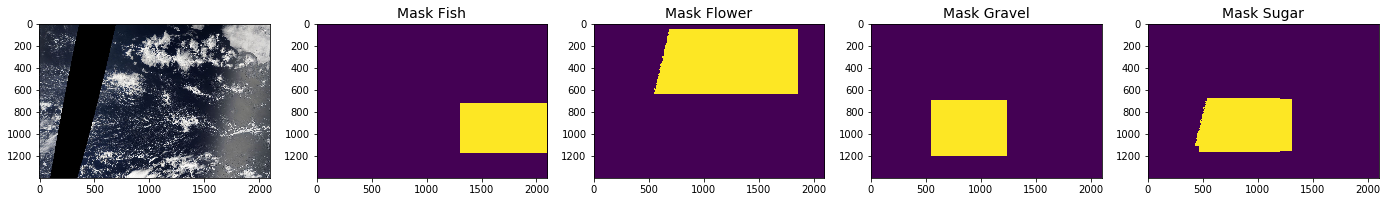

In [15]:
visualize(image, mask)

In [18]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = None
model = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [19]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


In [20]:
num_workers = 0
bs = 4
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader,
}

In [21]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.__name__ = "BCEDiceLoss"

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5 # TODO smooth may be 1?
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [22]:
num_epochs = 19
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
loss = BCEDiceLoss()
loss.__name__ = "BCEDiceLoss" # TODOこれを入れないとなんかエラー起きる
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
# train_epoch = smp.utils.train.TrainEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     optimizer=optimizer,
#     device=torch_device,
#     verbose=True,
# )

# valid_epoch = smp.utils.train.ValidEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     device=torch_device,
#     verbose=True,
# )

In [25]:
model = torch.load('../best_dice_model.pth')

In [26]:
from tqdm import tqdm
class test():
    def __init__(self, model, dataloader, device, loss, batch_size=4):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.loss = loss
        self.batch_size = batch_size
        
    def get_score(self, input, target):
        smooth = 1e-5 # TODO smooth may be 1?
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        
        return dice
        
    def run(self, aug=False):
        total_loss = 0.
        cnt = 0.
        score = 0.
        with torch.no_grad():
            for x, y in tqdm(self.dataloader):
                pred = self.model.forward(x.to(self.device))
                l = self.loss(pred.cpu(), y.cpu())
                total_loss += l.sum().numpy()
                score += self.get_score(pred.cpu(), y.cpu())
                cnt += self.batch_size

        return total_loss/cnt, score.numpy() /cnt

class TTA(test):
    def __init__(self, model, dataloader, device, loss, batch_size=4):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.loss = loss
        self.batch_size = batch_size
        
    def flip(self, x, axis):
        pred = self.model.forward(x.flip(axis).to(self.device))
        return pred.flip(axis)
        
    def run(self, augs_dict=None):
        total_loss = 0.
        score = 0.
        cnt = 0.
        with torch.no_grad():
            for x, y in tqdm(self.dataloader):
                pred1 = self.model.forward(x.to(self.device))
                pred2 = self.flip(x.to(self.device), 2)
                pred3 = self.flip(x.to(self.device), 3)
                pred = (pred1+pred2+pred3)/3.0
                l = self.loss(pred.cpu(), y.cpu())
                total_loss += l.sum().numpy()
                score += self.get_score(pred.cpu(), y.cpu())
                cnt += self.batch_size

        return total_loss/cnt, score.numpy() /cnt

In [27]:
x, y = iter(loaders['valid']).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


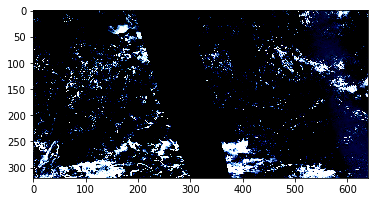

In [30]:
plt.imshow(x[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


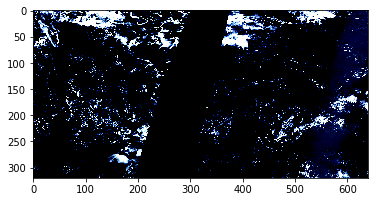

In [31]:
plt.imshow(x.flip(2)[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


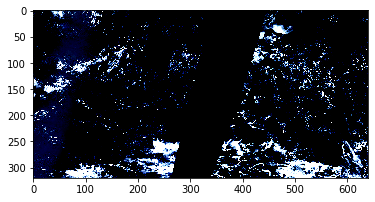

In [32]:
plt.imshow(x.flip(3)[0].permute(1, 2, 0))

In [30]:
tester = test(model, loaders['valid'], device, BCEDiceLoss())
tta_tester = TTA(model, loaders['valid'], device, BCEDiceLoss())

In [31]:
loss, score = tester.run()
print(loss)
print(score)

100%|██████████| 139/139 [01:20<00:00,  1.73it/s]

0.1611392083678314
0.12110743076681234


In [ ]:
tta_tester.run()
print(loss)
print(score)

 81%|████████  | 112/139 [01:25<00:20,  1.29it/s]

In [36]:
import sys
import torch
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter

class Epoch:

    def __init__(self, model, loss, metrics, stage_name, device='cpu', verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model).to(self.device)
            loss_name = self.loss.__name__
            self.loss = torch.nn.DataParallel(self.loss).to(self.device)
            self.loss.__name__ = loss_name
            for metric in self.metrics:
                metric = torch.nn.DataParallel(metric).to(self.device)
        else:
            self.model.to(self.device)
            self.loss.to(self.device)
            for metric in self.metrics:
                metric.to(self.device)
        # self.model.to(self.device)
        # self.loss.to(self.device)
        # for metric in self.metrics:
        #     metric.to(self.device)


    def _format_logs(self, logs):
        str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
        s = ', '.join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            for x, y in iterator:
                # if self.device =='cuda':
                #     x, y = torch.nn.DataParallel(x), torch.nn.DataParallel(y)
                # else:
                #     x, y = x.to(self.device), y.to(self.device)
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)
                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)



class ValidEpoch(Epoch):

    def __init__(self, model, loss, metrics, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='valid',
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
            if self.device =='cuda':
                loss = loss.sum()
        return loss, prediction



In [54]:
y.shape

torch.Size([4, 4, 320, 640])

In [55]:
pred = model(x.to(device))

In [56]:
pred.shape

torch.Size([4, 4, 320, 640])